<a href="https://colab.research.google.com/github/abhinav-exp/Forecasting-CryptoCurrency-Prices/blob/master/TFLANN_with_JAYA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
GitHubDataLink = 'https://raw.githubusercontent.com/abhinav-exp/Forecasting-CryptoCurrency-Prices/master/Datasets/'
InputFileLink = GitHubDataLink + 'DataBTC2017.csv'
data1 = pd.read_csv(InputFileLink, header=0, index_col=0)
print(data1)

            CBBTCUSD
DATE                
2017-06-18   2515.25
2017-06-19   2596.98
2017-06-20   2725.08
2017-06-21   2643.35
2017-06-22   2679.99
...              ...
2019-08-03  10820.75
2019-08-04  10997.82
2019-08-05  11775.14
2019-08-06  11440.08
2019-08-07  12014.41

[781 rows x 1 columns]


In [3]:
data1min = data1.min()
data1max = data1.max()

normalize = lambda x: (x - data1min + 1)/(data1max - data1min + 2)
data2 = normalize(data1)
print(data2)

            CBBTCUSD
DATE                
2017-06-18  0.034073
2017-06-19  0.038680
2017-06-20  0.045901
2017-06-21  0.041294
2017-06-22  0.043360
...              ...
2019-08-03  0.502247
2019-08-04  0.512228
2019-08-05  0.556045
2019-08-06  0.537158
2019-08-07  0.569532

[781 rows x 1 columns]


In [4]:
def split_sequence(sequence, n_steps):
  X= list()
  for i in range(len(sequence) - n_steps):
    end_ix = i + n_steps
    seq_x= sequence.values[i:end_ix, 0]
    X.append(seq_x) 
  return pd.DataFrame(X)

data3 = split_sequence(data2, 10)
print(data3.shape)
print(data3)

(771, 10)
            0         1         2         3         4         5         6  \
0    0.034073  0.038680  0.045901  0.041294  0.043360  0.043967  0.037432   
1    0.038680  0.045901  0.041294  0.043360  0.043967  0.037432  0.033530   
2    0.045901  0.041294  0.043360  0.043967  0.037432  0.033530  0.028023   
3    0.041294  0.043360  0.043967  0.037432  0.033530  0.028023  0.037484   
4    0.043360  0.043967  0.037432  0.033530  0.028023  0.037484  0.036208   
..        ...       ...       ...       ...       ...       ...       ...   
766  0.441959  0.449255  0.447073  0.426045  0.430599  0.427984  0.432307   
767  0.449255  0.447073  0.426045  0.430599  0.427984  0.432307  0.461562   
768  0.447073  0.426045  0.430599  0.427984  0.432307  0.461562  0.479501   
769  0.426045  0.430599  0.427984  0.432307  0.461562  0.479501  0.486030   
770  0.430599  0.427984  0.432307  0.461562  0.479501  0.486030  0.502247   

            7         8         9  
0    0.033530  0.028023  0.03

In [6]:
train_x = data3.iloc[:int(0.85*len(data2)), :9]
train_y = data3.iloc[:int(0.85*len(data2)), 9:10]
test_x = data3.iloc[int(0.85*len(data2)):, :9]
test_y = data3.iloc[int(0.85*len(data2)):, 9:10]
print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

(663, 9)
(663, 1)
(108, 9)
(108, 1)


In [146]:
class TFLANN():
  def __init__(self, W):
    self.weight_matrix = W
  
  def func_x(self, x):
    const_x = np.ones((len(x), 1))
    orginal_x = x
    sinned_x = np.sin(np.pi*x)
    cossed_x = np.cos(np.pi*x)
    functioned_x = np.hstack((x, sinned_x, cossed_x, const_x))
    return functioned_x

  def forward_propagation(self, x):
    funced_x = self.func_x(x)
    return (np.tanh(np.dot(funced_x, self.weight_matrix)) + 1)/2

In [206]:
find_mse = lambda x , y: np.mean(abs(x - y))

class JAYATFLANN():
  def __init__(self, p_size):
    self.p_size = p_size
    self.data = []

    for i in range(p_size):
      d = {}
      d['W'] = 2*np.random.random((9*3 + 1, 1)) - 1
      model = TFLANN(d['W'])
      d['mse'] = find_mse(model.forward_propagation(train_x), train_y)
      self.data.append(d)

    print(sum([v['mse'][9] for v in self.data]))
    print([v['mse'][9] for v in self.data])

    self.update_best_and_worst()

  def update_best_and_worst(self):
    self.best = 0
    self.worst = 0
    for i in range(self.p_size):
      if self.data[self.best]['mse'][9] > self.data[i]['mse'][9]:
        self.best = i
      if self.data[self.worst]['mse'][9] < self.data[i]['mse'][9]:
        self.worst = i

  def next_gen(self):
    for i in range(self.p_size):
      t =  self.data[i]['W']
      t += 1.0* np.random.random((9*3 + 1, 1))* (self.data[self.best]['W'] - self.data[i]['W'])
      # t -= np.random.random((9*3 + 1, 1))* (self.data[self.worst]['W'] - self.data[i]['W'])
      model = TFLANN(t)
      mse = find_mse(model.forward_propagation(train_x), train_y)
      if mse[9] < self.data[i]['mse'][9]:
        self.data[i] = {'W': t, 'mse':mse}

    self.update_best_and_worst()

  def optimise(self, gen):
    for i in range(gen):
      self.next_gen()
      print(str(self.data[self.best]['mse'][9]) + "\t" + str(self.data[self.worst]['mse'][9]))

In [212]:
optimiser = JAYATFLANN(50)
optimiser.optimise(100)
model = TFLANN(optimiser.data[optimiser.best]['W'])
preds = model.forward_propagation(test_x)
print(preds.shape)

20.451685111007702
[0.6966904107595855, 0.22154079605174493, 0.2420849025776553, 0.7479174114159867, 0.15919375825362925, 0.29484720268248643, 0.22777218566218754, 0.23643171272510652, 0.7234593532725996, 0.2069788044225676, 0.1293597725835366, 0.7320993896870719, 0.22232652355285296, 0.6350943859948093, 0.2155144662301393, 0.13057948633602184, 0.6816844127757726, 0.6202836310283597, 0.14497411410871283, 0.33937931033155894, 0.6487144945176234, 0.7114683270506555, 0.3218052263277068, 0.49000261106573806, 0.6295677709955712, 0.7237891751234664, 0.22144677430107496, 0.7034241260938485, 0.47892817540916666, 0.2225748268451118, 0.22081493779801634, 0.12797070513166048, 0.25190050576356604, 0.27008000504710455, 0.3776791794155241, 0.26344000651232957, 0.24189113516519206, 0.34876003196856453, 0.6272994557095686, 0.22563084011660245, 0.1840792427952009, 0.5631847974189476, 0.62070809291145, 0.4703722503382287, 0.21711206906348476, 0.5046731752001176, 0.2401494175247172, 0.7109384192389485, 0

In [213]:
preds[:, 0]

array([0.17494306, 0.17525126, 0.17174485, 0.17988335, 0.18007287,
       0.17373952, 0.16865134, 0.1654735 , 0.15938524, 0.15845064,
       0.16981732, 0.17287125, 0.17104837, 0.18235671, 0.19301866,
       0.19531831, 0.19469811, 0.19885372, 0.1973005 , 0.201347  ,
       0.21790829, 0.24819308, 0.26870614, 0.29092962, 0.32497548,
       0.34267264, 0.33200353, 0.32628709, 0.30066054, 0.29102919,
       0.29765907, 0.32448485, 0.36876335, 0.37039661, 0.32258529,
       0.31132613, 0.34910744, 0.404863  , 0.39955671, 0.41001665,
       0.39201245, 0.36033271, 0.36287616, 0.36736119, 0.39092195,
       0.38095226, 0.35913773, 0.32684506, 0.30895269, 0.35092337,
       0.36391047, 0.36845731, 0.34419873, 0.32867781, 0.3509397 ,
       0.37835669, 0.39120625, 0.40277965, 0.4196859 , 0.43425372,
       0.41873189, 0.43882113, 0.44069956, 0.4737138 , 0.51790252,
       0.55080453, 0.57687803, 0.54743792, 0.56501226, 0.57083256,
       0.66547264, 0.50730039, 0.58501388, 0.61147378, 0.51187

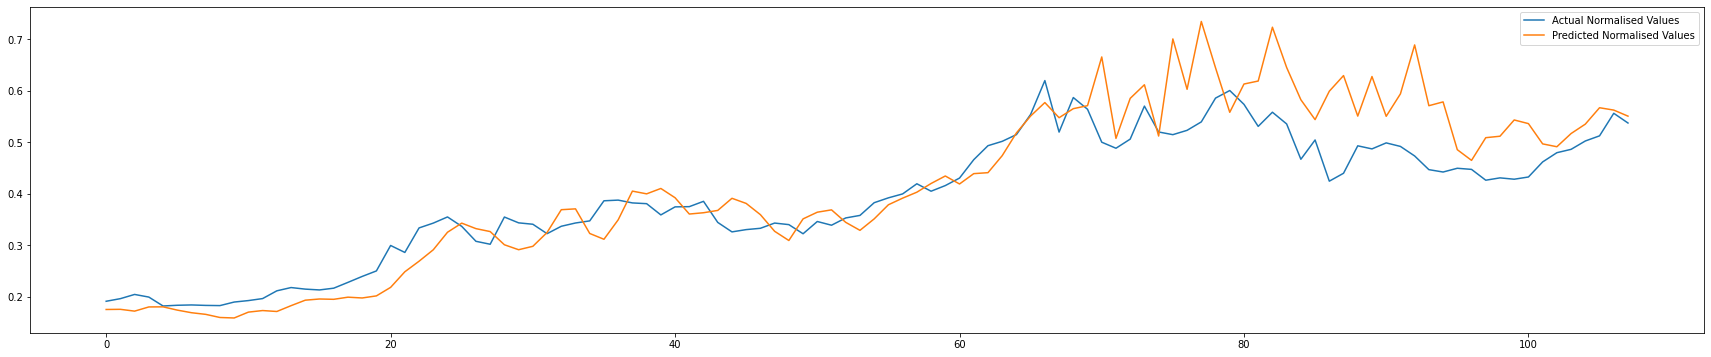

In [214]:
plt.figure(figsize=(30, 6))
plt.plot(test_y.reset_index()[9])
plt.plot(preds)
plt.legend(["Actual Normalised Values", "Predicted Normalised Values"])
plt.show()

In [215]:
d1 = (data1max - data1min + 2)[0]
print(type(d1))
denormalized_preds = (preds*d1)[:,0]
# print(denormalized_preds)
denormalized_preds += (data1min + 1)[0]
# print(denormalized_preds)
preds1 = pd.DataFrame(denormalized_preds)
preds1['DATE'] = data1.index[-1*len(preds1):]
preds1 = preds1.set_index('DATE')
print(preds1)

<class 'numpy.float64'>
                       0
DATE                    
2019-04-22   5016.310174
2019-04-23   5021.777603
2019-04-24   4959.573156
2019-04-25   5103.952013
2019-04-26   5107.314069
...                  ...
2019-08-03  11079.629043
2019-08-04  11403.525079
2019-08-05  11968.447236
2019-08-06  11887.585884
2019-08-07  11678.850261

[108 rows x 1 columns]


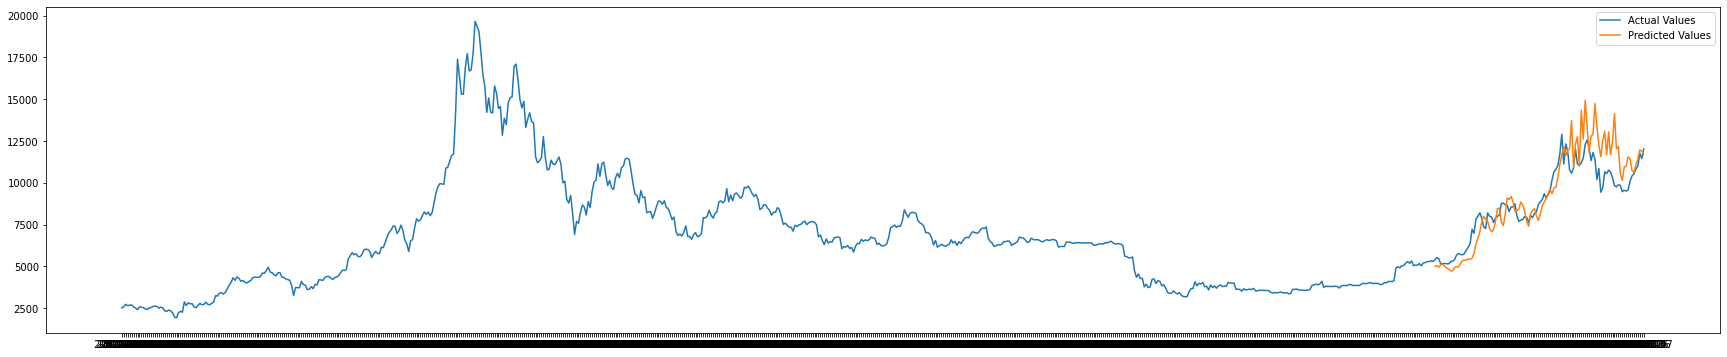

In [216]:
plt.figure(figsize=(30, 6))
plt.plot(data1)
plt.plot(preds1)
plt.legend(["Actual Values", "Predicted Values"])
plt.show()

In [217]:
mse = np.mean((np.array(preds1[0]) - np.array(data1.iloc[-1*(len(preds1)):, 0]))**2)
print("mse  "+ str(mse))
print("rmse "+ str(np.sqrt(mse)))

mse  1523813.6435866551
rmse 1234.4284683960652
